# Проект: Аналитика  A/A/B-эксперимента по замене шрифта в приложении

**Описание проекта**

Нужно разобраться, как ведут себя пользователи вашего мобильного приложения, которое продаёт продукты питания.

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие.

- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth

#import datetime as dt
from datetime import datetime, timedelta


# настроим отображение датафрейма
# поставим вывод всех столбцов
pd.set_option('display.max_columns', None)
# поставим вывод всех строк
pd.set_option('display.max_rows', None)

# отображаем весь текст в ячейке
pd.set_option('display.max_colwidth', None)


import sys
# для вывода всех значений в массиве
np.set_printoptions(threshold=sys.maxsize)

In [2]:
# загрузим файл с данными
data = pd.read_csv('C:/Users/Sam/DA/Projects_YandexPracticum/Project8_mobile_app/logs_exp.csv', sep='\t')

In [3]:
# просмотрим датафрейм
display(data.head())
display(data.tail())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


,EventName,DeviceIDHash,EventTimestamp,ExpId
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246
244125,OffersScreenAppear,5746969938801999050,1565212517,246


В датафрейме названия столбцов не соответствуют 'змеиному стилю'. Будем менять названия столбцов.

Также значения даты непонятны в столбце EventTimestamp. Возможно проблема с типом данных. 

In [4]:
# просмотрим информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


В столбце EventTimestamp неверный тип данных. Будем исправлять на тип datetime.

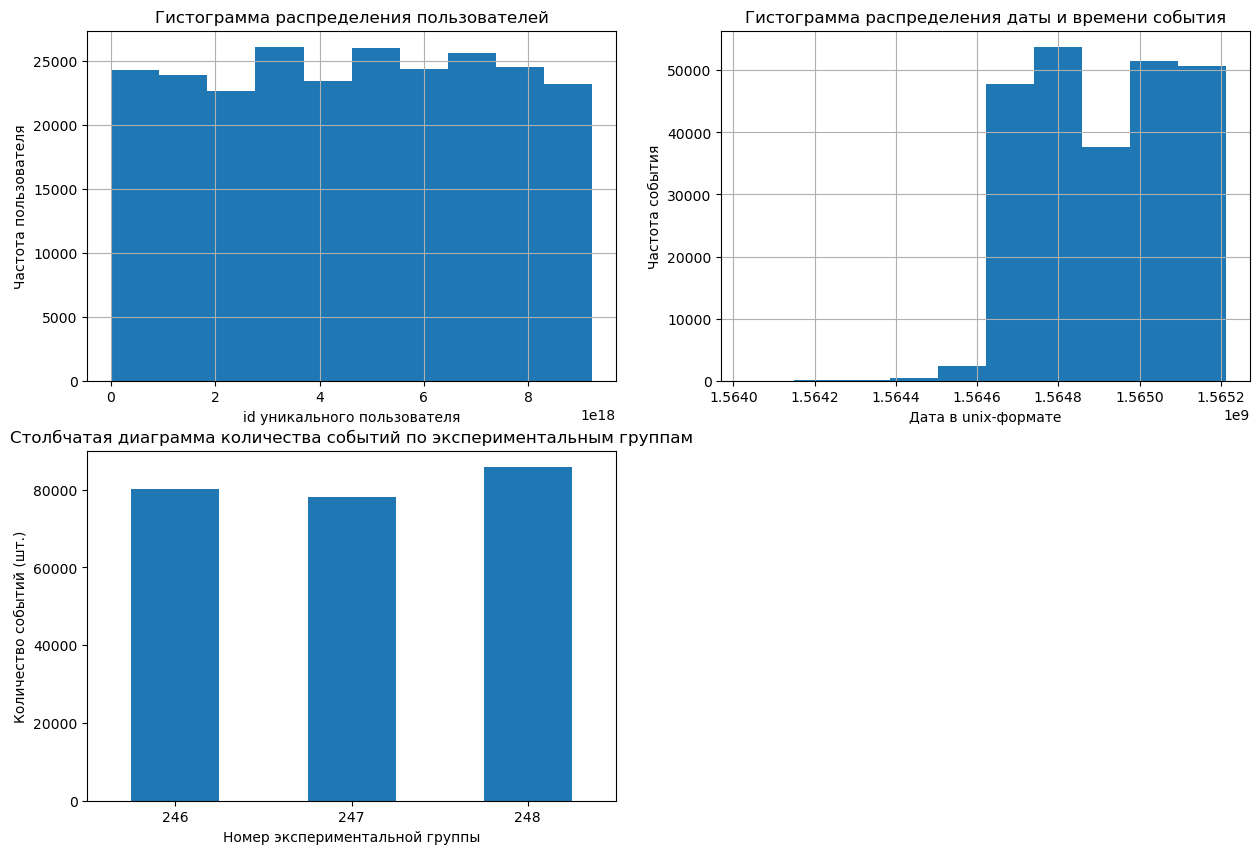

In [5]:
# построим графики по датафрейму
plt.figure(figsize=(15,10))

ax1 = plt.subplot(2, 2, 1)
data['DeviceIDHash'].hist(ax=ax1)
plt.title('Гистограмма распределения пользователей')
plt.xlabel('id уникального пользователя')
plt.ylabel('Частота пользователя')

ax2 = plt.subplot(2, 2, 2)
data['EventTimestamp'].hist(ax=ax2)
plt.title('Гистограмма распределения даты и времени события')
plt.xlabel('Дата в unix-формате')
plt.ylabel('Частота события')

ax3 = plt.subplot(2, 2, 3)
data.groupby('ExpId')['ExpId'].count().plot(kind='bar', ax=ax3)
plt.title('Столбчатая диаграмма количества событий по экспериментальным группам')
plt.xlabel('Номер экспериментальной группы')
plt.ylabel('Количество событий (шт.)')
plt.xticks(rotation=0)

plt.show()

Видны проблемы со столбцом EventTimestamp, который хранит время события. Распределение скошено влево. Что может означать присутствие дат с более ранним периодом. Время сохранено в формате Unix-времени, которое непонятно обычному человеку. Для отображения обычного формата времени столбец необходимо привести к типу данных datetime. После изменения формата временеи проверим еще раз распределение.

Со столбцами DeviceIDHash, который хранит уникальный идентификатор пользователя, и ExpId, который хранит номер эксперимента, проблем не видно.

**Выводы по главе:**
1. Файл с данными был загружен и просмотрен. Была изучена общая информация о датафрейме.
2. В датафрейме названия столбцов не соответствуют 'змеиному стилю'. Будем менять названия столбцов.
3. В столбце EventTimestamp неверный тип данных. Время сохранено в формате Unix-времени. Будем исправлять на тип datetime.
4. У столбца распределение скошено влево. Что может означать присутствие дат с более ранним периодом. Проверим еще раз после приведения к типу данных datetime.
5. Со столбцами DeviceIDHash и ExpId проблем не видно.

## Шаг 2. Подготовьте данные

- Замените названия столбцов на удобные для вас;
- Проверьте пропуски и типы данных. Откорректируйте, если нужно;
- Добавьте столбец даты и времени, а также отдельный столбец дат;

### Замена названий столбцов

In [6]:
# переименуем столбцы на соответствие 'змеиному стилю'
data = data.rename(columns={'EventName': 'event_name', 
                            'DeviceIDHash': 'device_id_hash', 
                            'EventTimestamp': 'event_timestamp', 
                            'ExpId': 'exp_id'})

### Проверка пропусков и типов данных

In [7]:
# исправим тип данных в столбце event_timestamp на datetime64
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='s')

# проверим изменения
display(data.info())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   device_id_hash   244126 non-null  int64         
 2   event_timestamp  244126 non-null  datetime64[ns]
 3   exp_id           244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


None

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [8]:
# проверим датафрейм на наличие пропусков
data.isna().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

Пропусков в датафрейме нет.

In [9]:
# проверим датафрейм на наличие дубликатов
data.duplicated().sum()

413

In [10]:
print('Процент дубликатов в датафрейме в %:', round((data.duplicated().sum() / len(data) * 100), 2))

Процент дубликатов в датафрейме в %: 0.17


Количество дубликатов мало: 0.17%. Дубликаты удалим из датафрейма.

In [11]:
# удалим дубликаты и обновим индекс
data = data.drop_duplicates().reset_index(drop=True)

In [12]:
# просмотрим уникальные значения в столбцах с event_name и exp_id
display(data['event_name'].sort_values().unique())
display(data['exp_id'].sort_values().unique())

array(['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear',
       'PaymentScreenSuccessful', 'Tutorial'], dtype=object)

array([246, 247, 248], dtype=int64)

Нет проблем в уникальных значениях в столбцах с event_name и exp_id. Мы проверили, что всего 3 группы эксперимента. И узнали, что есть 5 событий в эксперименте.

### Добавление столбца даты и времени, а также отдельного столбца дат

In [13]:
# добавим столбец с датой и временем и отдельный столбцец с датой
data['dt_time'] = data['event_timestamp']
data['dt'] = data['event_timestamp'].dt.date.astype('datetime64')

display(data.head())
display(data.info())

,event_name,device_id_hash,event_timestamp,exp_id,dt_time,dt
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25 11:48:42,2019-07-25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
 4   dt_time          243713 non-null  datetime64[ns]
 5   dt               243713 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 11.2+ MB


None

**Выводы по главе:**
1. Данные были подготовлены к анализу, проверены на пропуски. Дубликаты были удалены из датафрейма.
2. Названия столбцов были приведены к 'змеиному стилю'.
3. В столбце `event_timestamp` был изменен неверный тип данных на верный тип datetime64. Были созданы столбцы `dt_time` с датой и временем и `dt` с датой.
4. Были просмотрены уникальные значения в столбцах с event_name и exp_id. Мы проверили, что всего 3 группы эксперимента. А также узнали, что есть 5 событий в эксперименте.

## Шаг 3. Изучите и проверьте данные

### Сколько всего событий в логе?

In [14]:
# посчитаем общее количество событий
old_events_cnt = len(data)
print('Всего событий:', old_events_cnt)

Всего событий: 243713


### Сколько всего пользователей в логе?

In [15]:
# посчитаем уникальных пользователей
old_users_cnt = data['device_id_hash'].nunique()
print('Всего уникальных пользователей:', old_users_cnt)

Всего уникальных пользователей: 7551


### Сколько в среднем событий приходится на пользователя?

In [16]:
print('Среднее количество событий на пользователя:', round(data.groupby('device_id_hash').agg({'dt': 'count'}).mean(), 2))

Среднее количество событий на пользователя: dt    32.28
dtype: float64


### Данными за какой период вы располагаете?

#### Найдите максимальную и минимальную дату.

In [17]:
print('Минимальная дата исследования:', data['dt'].min())
print('Максимальная дата исследования:', data['dt'].max())

Минимальная дата исследования: 2019-07-25 00:00:00
Максимальная дата исследования: 2019-08-07 00:00:00


In [18]:
print('Период исследования:', data['event_timestamp'].max() - data['event_timestamp'].min())

Период исследования: 13 days 16:31:41


Исследование длилось неполных 14 дней с 25 июля 2019 по 07 августа 2019.

#### Постройте гистограмму по дате и времени.

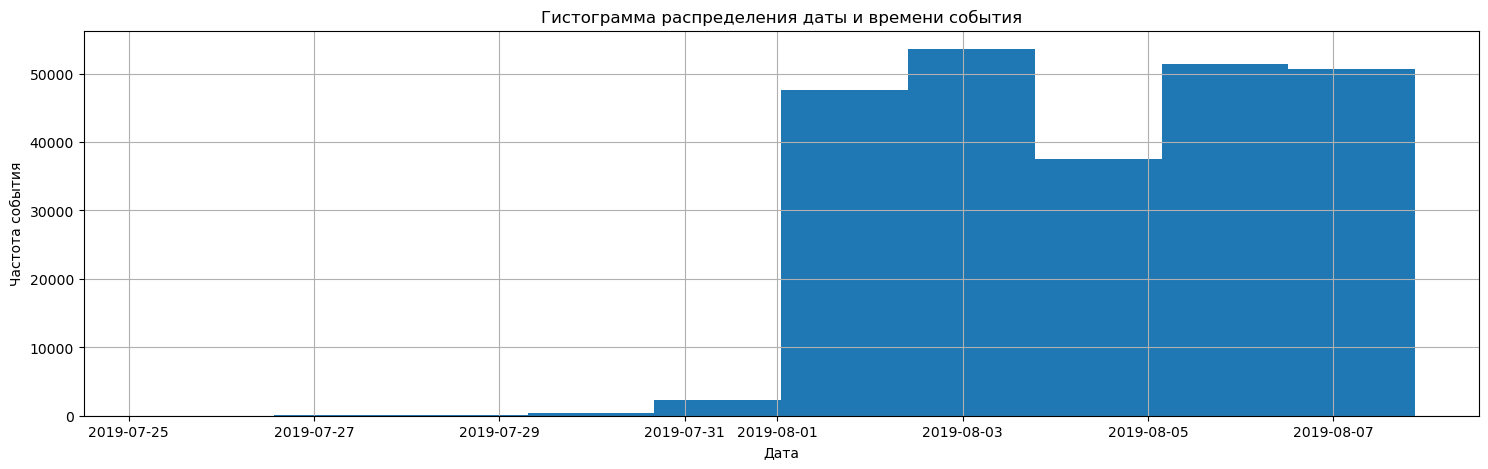

In [19]:
# посмотрим на гистограмму даты и времени
data['event_timestamp'].hist(figsize=(18, 5))
plt.xlabel('Дата')
plt.ylabel('Частота события')
plt.title('Гистограмма распределения даты и времени события')
plt.show()

У столбца `event_timestamp` распределение время события  осталось скошенным влево. Видно присутствие дат с более ранним периодом. 

Основное количество событий имеет дату от 08 августа 2019. Есть малое количество дат с 25 июля 2019 по 31 июля 2019.

Малое количество дат с более ранним периодом может повлиять на исследование.

#### Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». 

Сгруппируем данные по дате и посчитаем количество событий в определенную дату. Для наглядности высчитаем процент данных дня от общего количества событий и посчитаем процент с накоплением.

In [20]:
# группируем данные по дате, считаем количество событий в определенную дату
data_agg = data.groupby('dt').agg({'event_name': 'count'})
data_agg.columns = ['count_event_name']

# высчитаем долю процента данных по дню и сумму процента с накоплением
data_agg['percent'] = round(data_agg['count_event_name'] / data_agg['count_event_name'].sum() * 100, 2)
data_agg['percent_cumsum'] = data_agg['percent'].cumsum()

# посмотрим получившуюся таблицу
display(data_agg)

,count_event_name,percent,percent_cumsum
dt,,,
2019-07-25,9,0.00,0.00
2019-07-26,31,0.01,0.01
2019-07-27,55,0.02,0.03
2019-07-28,105,0.04,0.07
2019-07-29,184,0.08,0.15
2019-07-30,412,0.17,0.32
2019-07-31,2030,0.83,1.15
2019-08-01,36141,14.83,15.98
2019-08-02,35554,14.59,30.57


Как было замечано на гистограмме распределения даты и времени события, неполные данные идут с 25 июля 2019 по 31 июля 2019.

Общий процент событий за этот период составляет 1.15% от общего числа событий.

#### Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

Полные данные по событиям идут с 01 августа 2019 по 07 августа 2019. Данные до 01 августа 2019 неполны. 
Стоит отбросить данные в период с 25 июля 2019 по 31 июля 2019.

In [21]:
# перезапишем датафрейм, отбросив старые данные
data = data[data['dt'] >= '2019-08-01'].reset_index(drop=True)

# проверим данные
data.head()

,event_name,device_id_hash,event_timestamp,exp_id,dt_time,dt
0,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01 00:07:28,2019-08-01
1,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01 00:08:00,2019-08-01
2,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01 00:08:55,2019-08-01
3,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01 00:08:58,2019-08-01
4,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01 00:08:59,2019-08-01


### Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [22]:
# посчитаем общее количество событий после обработки данных
new_events_cnt = len(data)
print('Новое количество событий после отброса данных:', new_events_cnt)
print('Всего событий, которые мы потеряли после отброса данных:', old_events_cnt - new_events_cnt)
print('Процент событий, которые мы потеряли после отброса данных:', round(100 - (new_events_cnt / old_events_cnt * 100), 2))

Новое количество событий после отброса данных: 240887
Всего событий, которые мы потеряли после отброса данных: 2826
Процент событий, которые мы потеряли после отброса данных: 1.16


In [23]:
# посчитаем уникальных пользователей после обработки данных
new_users_cnt = data['device_id_hash'].nunique()
print('Новое количество уникальных пользователей после отброса данных:', new_users_cnt)
print('Всего уникальных пользователей, которых мы потеряли после отброса данных:', old_users_cnt - new_users_cnt)
print('Процент уникальных пользователей, которых мы потеряли после отброса данных:',
      round(100 - (new_users_cnt / old_users_cnt * 100), 2))

Новое количество уникальных пользователей после отброса данных: 7534
Всего уникальных пользователей, которых мы потеряли после отброса данных: 17
Процент уникальных пользователей, которых мы потеряли после отброса данных: 0.23


Отбросив старые данные, мы потеряли немного данных: 0.23% уникальных пользователей и 1.16% событий.

### Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [24]:
# сгруппируем данные по номеру экспериментальных групп и посчитаем число строк
data.groupby('exp_id').count()

,event_name,device_id_hash,event_timestamp,dt_time,dt
exp_id,,,,,
246,79302,79302,79302,79302,79302
247,77022,77022,77022,77022,77022
248,84563,84563,84563,84563,84563


Мы видим, что есть записи данных из 3 экспериментальных групп. Группы примерно равны по количеству записей.

### Проверим данные на наличие пользователей, которые входят в 2 или 3 группы эксперимента

In [25]:
# сгруппируем данные по пользователю, найдем сами уникальные групп и их количество у каждого пользователя
cross_users = data.groupby('device_id_hash').agg({'exp_id': ['unique', 'nunique']})

# переименуем столбцы
cross_users.columns = ['unique_groups', 'cnt_unique_groups']

# отсортируем по убыванию количества групп в которые входит пользователь
cross_users = cross_users.sort_values(by='cnt_unique_groups', ascending=False)
display(cross_users.head())

# найдем пересекающихся пользователей
print('Количество пересекающихся пользователей:', len(cross_users[cross_users['cnt_unique_groups'] > 1]))

,unique_groups,cnt_unique_groups
device_id_hash,,
6888746892508752,[246],1
6204944347213293942,[248],1
6215559225876063378,[248],1
6215162890135937308,[247],1
6213626876710715478,[246],1


Количество пересекающихся пользователей: 0


В исследовании нет пересекающихся пользователей, которые входят в 2 или 3 группы эксперимента.

**Выводы по главе:**

1. До отброса старых данных у нас было: 243 713 событий и 7 551 уникальных пользователей. Среднее количество событий на пользователя составляло 32.28 события. 
2. Минимальная дата исследования: 25 июля 2019. Максимальная дата исследования: 07 августа 2019.
3. Исследование длилось неполных 14 дней с 25 июля 2019 по 07 августа 2019.
4. Неполные данные идут с 25 июля 2019 по 31 июля 2019. Общий процент событий за этот период составляет 1.15% от общего числа событий.
5. Отбросив старые данные, мы потеряли немного данных: 1.16% событий (2826 событий) и 0.23% уникальных пользователей (17 пользователей)
6. Новое количество событий после отброса данных: 240 887. Новое количество уникальных пользователей после отброса данных: 7 534.
7. В исследовании нет пересекающихся пользователей, которые входят в 2 или 3 группы эксперимента.

## Шаг 4. Изучите воронку событий

### Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [26]:
# сгруппируем данные по событиям, узнаем их количество
event_ratio = data.groupby('event_name').agg({'device_id_hash': 'count'})
event_ratio.columns = ['event_count']
event_ratio = event_ratio.sort_values(by='event_count', ascending=False)

# просмотрим таблицу
display(event_ratio)

,event_count
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


Всего у нас 5 типов событий по убыванию частоты: 
 - `MainScreenAppear` - просмотр окна главного экрана,
 - `OffersScreenAppear` - просмотр окна экрана предложения,
 - `CartScreenAppear` - просмотр окна экрана оплаты с карты,
 - `PaymentScreenSuccessful` - просмотр окна экрана успешной оплаты,
 - `Tutorial` - просмотр окна с руководством.
 
 Самое редкое событие это просмотр окна с руководством. Предположим, что его можно пропустить и большинству пользователей помощь в приложении не нужна.
 
 Уменьшение частоты событий соответствует логике покупки. Просмотр главного экрана, просмотр предложения, оплата с карты, сообщение об успешной оплате.
 
 На данный момент проблем не видно.

### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [27]:
# сгруппируем данные по уникальным пользователям
user_ratio = data.groupby('event_name').agg({'device_id_hash': 'nunique'})
user_ratio.columns = ['user_count']
user_ratio = user_ratio.sort_values(by='user_count', ascending=False).reset_index()

# рассчитаем долю пользователей, которые хоть раз совершали событие, от числа пользователей после отброса старых данных 
user_ratio['percent'] = round((user_ratio['user_count'] / new_users_cnt * 100), 2)

# просмотрим таблицу
display(user_ratio)

,event_name,user_count,percent
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


In [28]:
# проверим значения по количеству уникальных пользователей после отброса старых данных в переменной new_users_cnt
print('Новое количество уникальных пользователей после отброса данных (в переменной new_users_cnt):', new_users_cnt)
print('Новое количество уникальных пользователей после отброса данных (путем подсчета уникальных пользователей):',
        data['device_id_hash'].nunique())

Новое количество уникальных пользователей после отброса данных (в переменной new_users_cnt): 7534
Новое количество уникальных пользователей после отброса данных (путем подсчета уникальных пользователей): 7534


Порядок частоты событий с сортировкой по уникальным пользователям совпадает с частотой событий с сортировкой по их количеству.
 
Опять самое редкое событие это просмотр окна с руководством. Скорее всего его можно пропустить.
 
И в этом случае уменьшение частоты событий соответствует логике покупки. Просмотр главного экрана, просмотр предложения, оплата с карты, сообщение об успешной оплате.
 
Также проблем не видно.

### Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

После анализа частоты событий составим воронку. 

**Предположим, что порядок событий в приложении такой:**

1. `MainScreenAppear` - просмотр окна главного экрана,
2. `OffersScreenAppear` - просмотр окна экрана предложения,
3. `CartScreenAppear` - просмотр окна экрана оплаты с карты,
4. `PaymentScreenSuccessful` - просмотр окна экрана успешной оплаты.

**Данный шаг можно пропустить, в воронку включать не будем:**

1. `Tutorial` - просмотр окна с руководством
 
Порядок событий соответствует логике покупки. Пользователь заходит на главный экран, переходит на экран предложения, оплачивает заказ, получает подтверждение успешной оплаты.
 
Отдельно выделили самое редкое событие: просмотр окна с руководством. Предположим, что его можно пропустить. Большинству пользователей помощь в приложении не нужна, поэтому показатель низкий. 

Если мы включим данное событие в воронку, оно сделает конверсию очень низкой. Поэтому мы не включаем его в воронку.

### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 

**То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.**

In [29]:
# построим воронку с churn_rate, исключим событие Tutorial
churn_rate_funnel = user_ratio[['event_name', 'user_count']].query('event_name != "Tutorial"')
# создадим столбец со смещением числа пользователей для подсчета churn_rate
churn_rate_funnel['previous'] = churn_rate_funnel['user_count'].shift(periods=1, fill_value=0)
# посчитаем churn_rate
churn_rate_funnel['churn_rate'] = round((1 - churn_rate_funnel['user_count'] / churn_rate_funnel['previous']) * 100, 2)
# заменим отрицательное значение на 0 в churn_rate
churn_rate_funnel.replace([-np.inf], 0, inplace=True)

# посмотрим на воронку событий
display(churn_rate_funnel[['event_name', 'user_count', 'churn_rate']])

,event_name,user_count,churn_rate
0,MainScreenAppear,7419,0.00
1,OffersScreenAppear,4593,38.09
2,CartScreenAppear,3734,18.70
3,PaymentScreenSuccessful,3539,5.22


Воронка событий построена.

### На каком шаге теряете больше всего пользователей?

Больше всего пользователей мы теряем на 1 шаге во время просмотра главного экрана (событие `MainScreenAppear`). До следующего шага не доходит 38.09% пользователей с текущего шага.

Далее коэффициент отскока уменьшается. 

### Какая доля пользователей доходит от первого события до оплаты?

In [30]:
print('От первого события (MainScreenAppear) до оплаты (PaymentScreenSuccessful) не доходит % пользователей:',
      round(churn_rate_funnel['user_count'][3] / churn_rate_funnel['user_count'][0] * 100, 2))

От первого события (MainScreenAppear) до оплаты (PaymentScreenSuccessful) не доходит % пользователей: 47.7


**Выводы по главе:**

1. Всего у нас 5 типов событий по убыванию частоты:
   - MainScreenAppear - просмотр окна главного экрана,
   - OffersScreenAppear - просмотр окна экрана предложения,
   - CartScreenAppear - просмотр окна экрана оплаты с карты,
   - PaymentScreenSuccessful - просмотр окна экрана успешной оплаты,
   - Tutorial - просмотр окна с руководством.
   
2. Уменьшение частоты событий соответствует логике покупки. Просмотр главного экрана, просмотр предложения, оплата с карты, сообщение об успешной оплате. Самое редкое событие это просмотр окна с руководством. Было предположено, что его можно пропустить и большинству пользователей помощь в приложении не нужна.
    
3. Порядок частоты событий с сортировкой по уникальным пользователям совпадает с частотой событий с сортировкой по их количеству.

4. Была составлена воронка. Порядок событий в приложении такой:
   - MainScreenAppear - просмотр окна главного экрана,
   - OffersScreenAppear - просмотр окна экрана предложения,
   - CartScreenAppear - просмотр окна экрана оплаты с карты,
   - PaymentScreenSuccessful - просмотр окна экрана успешной оплаты.

5. В воронку не включили событие Tutorial (просмотр окна с руководством), т.к. данный шаг можно пропустить.

6. Больше всего пользователей мы теряем на 1 шаге во время просмотра главного экрана (событие MainScreenAppear). До следующего шага не доходит 38.09% пользователей с текущего шага. Далее коэффициент отскока уменьшается.

7. От первого события (MainScreenAppear) до оплаты (PaymentScreenSuccessful) не доходит % пользователей: 47.7

## Шаг 5. Изучите результаты эксперимента

### Сколько пользователей в каждой экспериментальной группе?

In [31]:
# сгруппируем данные по группе эксперимента, посчитаем уникальных пользователей
exp_users = data.groupby('exp_id')['device_id_hash'].nunique()

display(exp_users)

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

В группе 246: 2484 пользователя, в группе 247: 2513 пользователей, в группе 248: 2537 пользователей. Количество пользователей в группах примерно равно.

### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

Для проверки статистических критериев разницы между выборками будем использовать z-тест, который проверяет Гипотезы о равенстве долей.

Для начала сгруппируем данные для теста и напишем функцию, для проведения теста.

In [32]:
# сгруппируем данные в сводную таблицу, отсортируем по убыванию частоты событий
data_test = (data.pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique')
    .sort_values(by=246, ascending=False)
)

# добавим столбец с объединённой контрольной группой
data_test['246_and_247'] = data_test[246] + data_test[247]

# посмотрим на собранные данные для теста
display(data_test)

exp_id,246,247,248,246_and_247
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358
Tutorial,278,283,279,561


In [33]:
# создадим таблицу с количеством пользователей в выборках по экспериментальным группам
display(exp_users)

# добавим строку с объединённой контрольной группой
exp_users.loc['246_and_247'] = exp_users.loc[246] + exp_users.loc[247]

# изменим тип с Series на DataFrame
exp_users = exp_users.to_frame(name='user_count')
display(exp_users)

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

,user_count
exp_id,
246,2484
247,2513
248,2537
246_and_247,4997


In [34]:
# создадим функцию для проверки экспериментальных групп
def test_z_value (group1, group2, event, alpha = 0.05):
    # функция принимает название 1 и 2 группы и название события для проверки
    # и критический уровень статистической значимости (по умолчанию 0.05);
    # функция выбирает данные по группам и событию;
    # далее проверяется гипотеза о равенстве долей в выборка с помощью z-теста
    # и возвращается результат о наличии статистической разнице между группами
    # alpha = 0.05 

    # наблюдаемая величина в 1 и 2 группе
    s1 = data_test.loc[event, group1]
    s2 = data_test.loc[event, group2]

    # размеры выборок групп 1 и 2
    n1 = exp_users.loc[group1]
    n2 = exp_users.loc[group2]

    # пропорция, наблюдаемая в 1 группе
    p1 = s1 / n1

    # пропорция, наблюдаемая во 2 группе
    p2 = s2 / n2

    # пропорция в скомбинированной выборке
    p_combined = (s1 + s2) / (n1 + n2)

    # разница пропорций в выборках
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / n1 + 1 / n2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    if p_value < alpha:
        print(f'Отвергаем нулевую гипотезу: \nмежду группами {group1} и {group2} есть значимая разница между долями по событию {event} при уровне значимости {alpha}')
        print('p-значение: ', p_value)
    else:
        print(
            f'Не получилось отвергнуть нулевую гипотезу, \nнет оснований считать группы {group1} и {group2} разными по долям по событию {event} при уровне значимости {alpha}')
        print('p-значение: ', p_value)

Проверим разницу по статистические критериям между выборками 246 и 247 по событию MainScreenAppear.


Также сформулируем гипотезы:

    Н0: Нет различий между долями по событию в проверяемых группах 1 и 2.
    H1: Есть различия между долями по событию в проверяемых группах 1 и 2.

In [35]:
# проверим работу функции
test_z_value(246, 247, 'MainScreenAppear', 0.05)

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 247 разными по долям по событию MainScreenAppear при уровне значимости 0.05
p-значение:  [0.75705972]


Была произведена проверка корректности всех механизмов и расчётов А/А-эксперимента с помощью z-теста.

Функция работает. Проблем не видно.

Предварительно считаем, что нет разницы по статистическим критериям по событию MainScreenAppear нет между контрольными группами 246 и 247 для А/А-эксперимента.

В следующем шаге проверку сделаем в цикле и проверим различия по оставшимся событиям между контрольными группами 246 и 247. И сделаем окончательный вывод.

### Выберите самое популярное событие. 

**Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?**

У нас сформулированы гипотезы:

    Н0: Нет различий между долями по событию в проверяемых группах 1 и 2.
    H1: Есть различия между долями по событию в проверяемых группах 1 и 2.
    
Проверим различия по оставшимся событиям между контрольными группами 246 и 247.

В датафрейме data_test уже посчитано число пользователей, совершивших событие в каждой из контрольных групп. Была сделано сортировка по уменьшению популярности событий.

Самое популярное событие: MainScreenAppear.

Проверим, будет ли отличие между группами статистически достоверным по всем событиям.

In [36]:
display(data_test)

exp_id,246,247,248,246_and_247
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358
Tutorial,278,283,279,561


In [37]:
# напишем функцию для проверки в цикле
def test_z_value_circle (group1, group2, alpha = 0.05):
# функция делает проверку по всем событиям в сравниваемых группах
# с помощью цикла для каждого значения индекса data_test вызывает функцию test_z_value
    for event in data_test.index:
        test_z_value(group1, group2, event, alpha)
        print()

In [38]:
# сделаем проверку между группами 246 и 247 по всем событиям
test_z_value_circle(246, 247, 0.05)

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 247 разными по долям по событию MainScreenAppear при уровне значимости 0.05
p-значение:  [0.75705972]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 247 разными по долям по событию OffersScreenAppear при уровне значимости 0.05
p-значение:  [0.24809546]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 247 разными по долям по событию CartScreenAppear при уровне значимости 0.05
p-значение:  [0.22883372]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 247 разными по долям по событию PaymentScreenSuccessful при уровне значимости 0.05
p-значение:  [0.11456679]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 247 разными по долям по событию Tutorial при уровне значимости 0.05
p-значение:  [0.93769962]



Была произведена окончательная проверка корректности всех механизмов и расчётов А/А-эксперимента с помощью z-теста.

Нет разницы  по статистическим критериям по всем событиям между контрольными группами 246 и 247 для А/А-эксперимента.

### Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

В датафреймах data_test и exp_users создали записи `246_and_247`, которые хранят значения объединенных контрольных групп 246 и 247.

Сделаем оставшиеся проверки.

In [39]:
# сделаем проверку между группой 246 и группой 248, у которой другой шрифт, по всем событиям
test_z_value_circle(246, 248, 0.05)

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 248 разными по долям по событию MainScreenAppear при уровне значимости 0.05
p-значение:  [0.29497219]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 248 разными по долям по событию OffersScreenAppear при уровне значимости 0.05
p-значение:  [0.20836205]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 248 разными по долям по событию CartScreenAppear при уровне значимости 0.05
p-значение:  [0.07842923]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 248 разными по долям по событию PaymentScreenSuccessful при уровне значимости 0.05
p-значение:  [0.21225533]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 248 разными по долям по событию Tutorial при уровне значимости 0.05
p-значение:  [0.8264294]



Нет статистической разницы по долям по всем событиям между контрольной группой 246 и группой 248, у которой другой шрифт. 

In [40]:
# сделаем проверку между группой 247 и группой 248, у которой другой шрифт, по всем событиям
test_z_value_circle(247, 248, 0.05)

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 247 и 248 разными по долям по событию MainScreenAppear при уровне значимости 0.05
p-значение:  [0.45870536]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 247 и 248 разными по долям по событию OffersScreenAppear при уровне значимости 0.05
p-значение:  [0.91978178]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 247 и 248 разными по долям по событию CartScreenAppear при уровне значимости 0.05
p-значение:  [0.57861979]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 247 и 248 разными по долям по событию PaymentScreenSuccessful при уровне значимости 0.05
p-значение:  [0.73734151]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 247 и 248 разными по долям по событию Tutorial при уровне значимости 0.05
p-значение:  [0.76532392]



Нет статистической разницы по долям по всем событиям между контрольной группой 247 и группой 248, у которой другой шрифт. 

In [41]:
# сделаем проверку между объединенной контрольной группой 246 и 247 и группой 248, у которой другой шрифт, по всем событиям
test_z_value_circle('246_and_247', 248, 0.05)

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246_and_247 и 248 разными по долям по событию MainScreenAppear при уровне значимости 0.05
p-значение:  [0.29424527]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246_and_247 и 248 разными по долям по событию OffersScreenAppear при уровне значимости 0.05
p-значение:  [0.4342555]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246_and_247 и 248 разными по долям по событию CartScreenAppear при уровне значимости 0.05
p-значение:  [0.18175875]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246_and_247 и 248 разными по долям по событию PaymentScreenSuccessful при уровне значимости 0.05
p-значение:  [0.60042943]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246_and_247 и 248 разными по долям по событию Tutorial при уровне значимости 0.05
p-значение:  [0.76486247]



Нет статистической разницы по долям по всем событиям между объединенной контрольной группой 246 и 247 и группой 248, у которой другой шрифт. 

### Какой уровень значимости вы выбрали при проверке статистических гипотез выше?

**Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.**

При проверки использовали уровень значимости alpha = 0.05. По всем группам и по всем событиям нет статистической разницы между долями при уровне значимости 0.05. Было сделано 20 проверок статистических гипотез.

Сделаем проверки с уровнем значимости 0.1 и 0.01.

In [42]:
# проверим все группы и события с уровнем значимости 0.01
test_z_value_circle(246, 247, 0.01)
test_z_value_circle(246, 248, 0.01)
test_z_value_circle(247, 248, 0.01)
test_z_value_circle('246_and_247', 248, 0.01)

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 247 разными по долям по событию MainScreenAppear при уровне значимости 0.01
p-значение:  [0.75705972]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 247 разными по долям по событию OffersScreenAppear при уровне значимости 0.01
p-значение:  [0.24809546]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 247 разными по долям по событию CartScreenAppear при уровне значимости 0.01
p-значение:  [0.22883372]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 247 разными по долям по событию PaymentScreenSuccessful при уровне значимости 0.01
p-значение:  [0.11456679]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 247 разными по долям по событию Tutorial при уровне значимости 0.01
p-значение:  [0.93769962]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 248 разным

По всем группам и по всем событиям нет статистической разницы между долями при уровне значимости 0.01. Было сделано 20 проверок статистических гипотез.

In [43]:
# проверим все группы и события с уровнем значимости 0.1
test_z_value_circle(246, 247, 0.1)
test_z_value_circle(246, 248, 0.1)
test_z_value_circle(247, 248, 0.1)
test_z_value_circle('246_and_247', 248, 0.1)

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 247 разными по долям по событию MainScreenAppear при уровне значимости 0.1
p-значение:  [0.75705972]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 247 разными по долям по событию OffersScreenAppear при уровне значимости 0.1
p-значение:  [0.24809546]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 247 разными по долям по событию CartScreenAppear при уровне значимости 0.1
p-значение:  [0.22883372]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 247 разными по долям по событию PaymentScreenSuccessful при уровне значимости 0.1
p-значение:  [0.11456679]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 247 разными по долям по событию Tutorial при уровне значимости 0.1
p-значение:  [0.93769962]

Не получилось отвергнуть нулевую гипотезу, 
нет оснований считать группы 246 и 248 разными по 

По всем группам и по всем событиям при уровне значимости 0.1 есть статистическая разница между долями только между группами 246 и 248 по событию CartScreenAppear при p-значении: 0.078. Что можно объяснить ложным результатом из-за высокого уровня alpha. Это ошибка первого рода.

Было сделано 20 проверок статистических гипотез.

После проверок с уровнем значимости 0.05, 0.1 и 0.01 остановимся на уровне значимости 0.05. Различий в результатах со значимостью 0.05 и 0.01 нет. При уровне в 0.1 различие было только в 1 тесте из 20, что объясняется ошибой первого рода.

При уровне 0.05 у нас больше вероятность не пропустить ошибку и увидеть действительные отличия между группами. Несмотря на то, что при этом уровне увеличивается вероятность ошибки первого рода по сравнению с уровнем значимости 0.01.


В итоге, при уровне значимости 0.05 мы не отвергаем нулевую гипотезу, Нет различий между долями по событию в проверяемых группах 1 и 2.

Значит, экспериментальная группа 248 с новым шрифтом не имеет статистических отличий по всем событиям с контрольными группами 246 и 247.

Также контрольные группы 246 и 247 со старым шрифтом не имеют статистических отличий по всем событиям между собой.

**Выводы по главе:**

1. Для проверки статистических критериев разницу между выборками был использован z-тест, который проверяет Гипотезы о равенстве долей.

2. Самое популярное событие у пользователей: MainScreenAppear (показ главного экрана).

3. Была произведена проверка корректности всех механизмов и расчётов А/А-эксперимента с помощью z-теста. Не было выявлено разницы  по статистическим критериям по всем событиям между контрольными группами 246 и 247 для А/А-эксперимента.

4. После проверок с уровнем значимости 0.05, 0.1 и 0.01 остановимся на уровне значимости 0.05. Различий в результатах со значимостью 0.05 и 0.01 нет. При уровне в 0.1 различие было только в 1 тесте из 20, что объясняется ошибой первого рода.

5. При уровне 0.05 у нас больше вероятность не пропустить ошибку и увидеть действительные отличия между группами. Несмотря на то, что при этом уровне увеличивается вероятность ошибки первого рода по сравнению с уровнем значимости 0.01.

6. В итоге, при уровне значимости 0.05 мы не отвергаем нулевую гипотезу, Нет различий между долями по событию в проверяемых группах 1 и 2.

7. Значит, экспериментальная группа 248 с новым шрифтом не имеет статистических отличий по всем событиям с контрольными группами 246 и 247.

8. Также контрольные группы 246 и 247 со старым шрифтом не имеют статистических отличий по всем событиям между собой.

## Вывод

Мы провели проверку и анализ A/A/B-эксперимента по замене шрифта в приложении. Данные были обработаны, проверены на пропуски, дубликаты и аномалии. Была изучена воронка продаж, был построен путь пользователя до покупки. Мы узнали сколько пользователей доходит до покупки, на каких шагах пользователи пропадают.

После подготовки данных, был произведен анализ результатов A/A/B-эксперимента. После этого мы ответили на поставленные вопросы исследования.

**Выводы по исследованию:** 

1. Данные были подготовлены к анализу, проверены на пропуски. Дубликаты были удалены из датафрейма. Мы проверили, что всего 3 группы эксперимента. А также узнали, что есть 5 событий в эксперименте.
2. До отброса старых данных у нас было: 243 713 событий и 7 551 уникальных пользователей. Среднее количество событий на пользователя составляло 32.28 события. 
3. Исследование длилось неполных 14 дней с 25 июля 2019 по 07 августа 2019.
4. Неполные данные идут с 25 июля 2019 по 31 июля 2019. Общий процент событий за этот период составляет 1.15% от общего числа событий.
5. Отбросив старые данные, мы потеряли немного данных: 1.16% событий (2826 событий) и 0.23% уникальных пользователей (17 пользователей)
6. Новое количество событий после отброса данных: 240 887. Новое количество уникальных пользователей после отброса данных: 7 534.
7. В исследовании нет пересекающихся пользователей, которые входят в 2 или 3 группы эксперимента.
8. Всего у нас 5 типов событий по убыванию частоты:
   - MainScreenAppear - просмотр окна главного экрана,
   - OffersScreenAppear - просмотр окна экрана предложения,
   - CartScreenAppear - просмотр окна экрана оплаты с карты,
   - PaymentScreenSuccessful - просмотр окна экрана успешной оплаты,
   - Tutorial - просмотр окна с руководством.   
9. Уменьшение частоты событий соответствует логике покупки. Просмотр главного экрана, просмотр предложения, оплата с карты, сообщение об успешной оплате. Самое редкое событие это просмотр окна с руководством. Было предположено, что его можно пропустить и большинству пользователей помощь в приложении не нужна.
10. Была составлена воронка. Порядок событий в приложении такой:
    - MainScreenAppear - просмотр окна главного экрана,
    - OffersScreenAppear - просмотр окна экрана предложения,
    - CartScreenAppear - просмотр окна экрана оплаты с карты,
    - PaymentScreenSuccessful - просмотр окна экрана успешной оплаты.
11. В воронку не включили событие Tutorial (просмотр окна с руководством), т.к. данный шаг можно пропустить.
12. Больше всего пользователей мы теряем на 1 шаге во время просмотра главного экрана (событие MainScreenAppear). До следующего шага не доходит 38.09% пользователей с текущего шага. Далее коэффициент отскока уменьшается.
13. От первого события (MainScreenAppear) до оплаты (PaymentScreenSuccessful) не доходит % пользователей: 47.7
14. Для проверки статистических критериев разницу между выборками был использован z-тест, который проверяет Гипотезы о равенстве долей.
15. Была произведена проверка корректности всех механизмов и расчётов А/А-эксперимента с помощью z-теста. Не было выявлено разницы  по статистическим критериям по всем событиям между контрольными группами 246 и 247 для А/А-эксперимента.
16. После проверок с уровнем значимости 0.05, 0.1 и 0.01 мы остановились на уровне значимости 0.05. Различий в результатах со значимостью 0.05 и 0.01 нет. При уровне в 0.1 различие было только в 1 тесте из 20, что объясняется ошибой первого рода.
17. **В итоге, при уровне значимости 0.05 мы не отвергаем нулевую гипотезу, Нет различий между долями по событию в проверяемых группах 1 и 2.**
18. **Экспериментальная группа 248 с новым шрифтом не имеет статистических отличий по всем событиям с контрольными группами 246 и 247.**
19. **Контрольные группы 246 и 247 со старым шрифтом не имеют статистических отличий по всем событиям между собой.**

**Рекомендации:**

Стоит применить новый шрифт в приложении ко всем пользователям. Экспериментальная группа с новым шрифтом не имеет статистических отличий по поведению в приложении и по показателям в сравнении с 2 контрольными группами.